In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simpson
import strawberryfields as sf
from strawberryfields.ops import *
from tqdm import tqdm
from scipy.linalg import eigh
from scipy.special import hermite, factorial
import sys
sys.path.insert(0, './../')
from gate_decompositions import *
import warnings
warnings.filterwarnings(action='ignore', module='strawberryfields')
sf.hbar = 1

In [4]:
def fock_wf(n, x):
    """Compute the wavefunction of the Fock state |n> at position x."""
    # Hermite polynomial
    Hn = hermite(n)
    # Prefactor
    prefactor = 1.0 / (np.sqrt(2**n * factorial(n) * np.sqrt(np.pi)))
    # Compute the wavefunction
    psi_n = prefactor * Hn(x) * np.exp(-x**2 / 2)
    return psi_n

def wf_from_fock_pure(fock_coeffs, x):
    state = 0
    for coeff, n in zip(fock_coeffs, range(len(fock_coeffs))):
        state += coeff*fock_wf(n, x)
    return state

# Cubic Phase Gate Test (Single Mode)

100%|██████████| 9/9 [01:52<00:00, 12.47s/it]


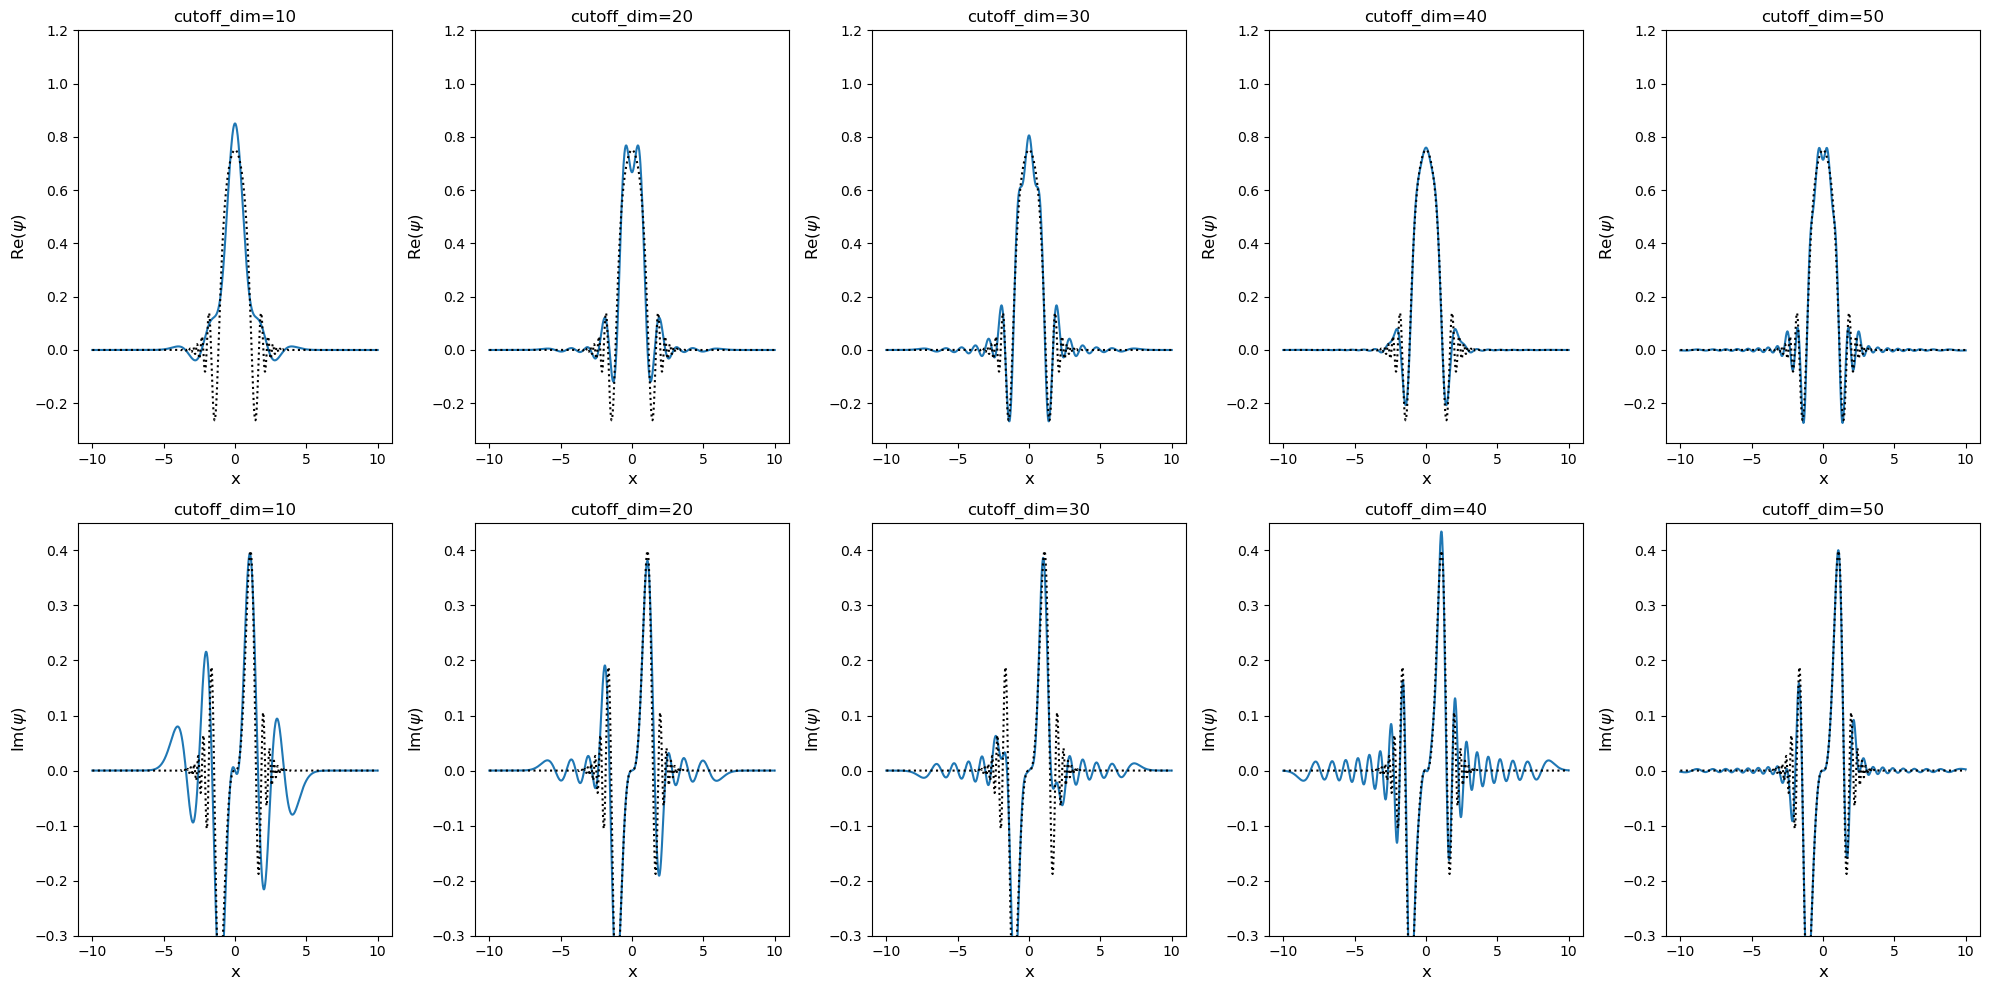

In [5]:
xvec = np.linspace(-10, 10, 1000)
pvec = np.copy(xvec)
true = 1/np.pi**(1/4)*np.exp(1j*xvec**3 - xvec**2/2)
cutoffs = list(range(10, 51, 5))
cols = 5
fig, ax = plt.subplots(2, cols, figsize=(20, 10))
ax = ax.ravel()
progress = tqdm(total=len(cutoffs))
trace_err = []
mix_err = []
mse_err = []
counter = 0
for cutoff in cutoffs:
    eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff})
    prog = sf.Program(2)
    with prog.context as q:
        Vac | q[0]
        Vgate(3) | q[0]
    result = eng.run(prog, shots=1)
    fock_dm = result.state.reduced_dm(0)
    probs = result.state.x_quad_values(0, xvec, pvec)
    eigenvalues, eigenvectors = eigh(fock_dm)
    trace_err.append(np.abs(np.trace(fock_dm)))
    mix_err.append(np.max(np.abs(eigenvalues)))
    mse_err.append(np.sum((np.abs(true)**2 - probs)**2))
    fock_rep = eigenvectors[:, np.argmax(eigenvalues)]
    psi = wf_from_fock_pure(fock_rep, xvec)
    mse_real = sum([np.abs(np.real(psi[i]) - np.real(true[i]))**2 for i in range(len(psi))])
    mse_imag = sum([np.abs(np.imag(psi[i]) - np.imag(true[i]))**2 for i in range(len(psi))])
    if cutoff%10==0:
        ax[counter].plot(xvec, np.real(psi), label='Quantum Simulation')
        ax[counter+cols].plot(xvec, np.imag(psi), label='Quantum Simulation')
        ax[counter].plot(xvec, np.real(true), color='k', linestyle=':', label='Analytical Solution')
        ax[counter+cols].plot(xvec, np.imag(true), color='k', linestyle=':', label='Analytical Solution')
        ax[counter].set_title(f'cutoff_dim={cutoff}', fontsize=12)
        ax[counter].set_xlabel('x', fontsize=12)
        ax[counter].set_ylabel(r'Re($\psi$)', fontsize=12)
        ax[counter].set_ylim(-.35, 1.2)
        ax[counter+cols].set_title(f'cutoff_dim={cutoff}', fontsize=12)
        ax[counter+cols].set_xlabel('x', fontsize=12)
        ax[counter+cols].set_ylim(-.3, .45)
        ax[counter+cols].set_ylabel(r'Im($\psi$)', fontsize=12)
        counter += 1
    progress.update(1)
progress.close()
plt.tight_layout()
plt.show()


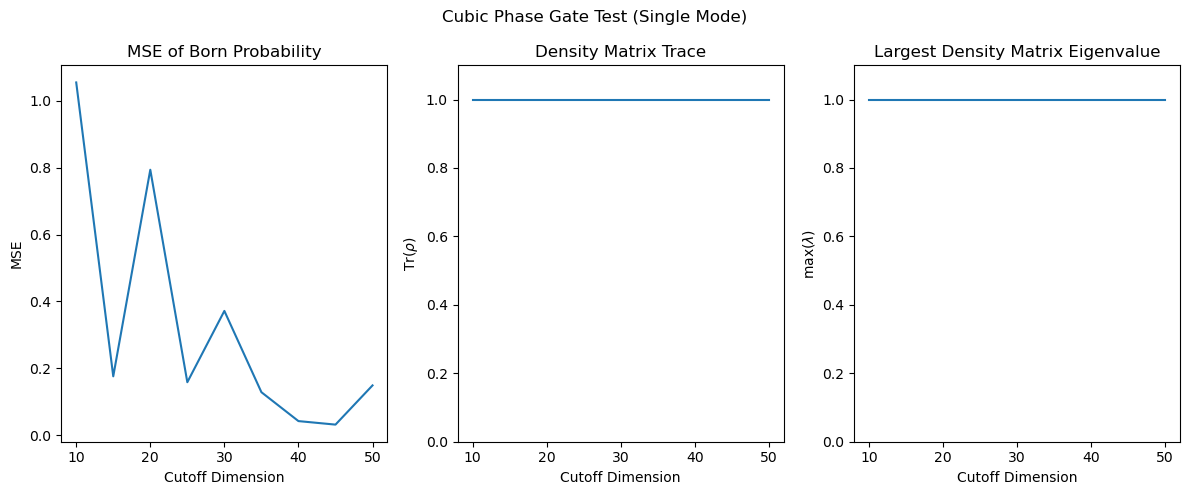

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].plot(cutoffs, mse_err)
ax[0].set_xlabel('Cutoff Dimension')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE of Born Probability')
ax[1].plot(cutoffs, trace_err)
ax[1].set_xlabel('Cutoff Dimension')
ax[1].set_ylabel(r'Tr($\rho$)')
ax[1].set_title('Density Matrix Trace')
ax[2].plot(cutoffs, mix_err)
ax[2].set_xlabel('Cutoff Dimension')
ax[2].set_ylabel(r'max($\lambda$)')
ax[2].set_title('Largest Density Matrix Eigenvalue')
ax[1].set_ylim(0, 1.1)
ax[2].set_ylim(0, 1.1)
plt.suptitle('Cubic Phase Gate Test (Single Mode)')
plt.tight_layout()
plt.show()

# Cubic Phase Gate Test (Two Modes)

100%|██████████| 9/9 [01:34<00:00, 10.51s/it]


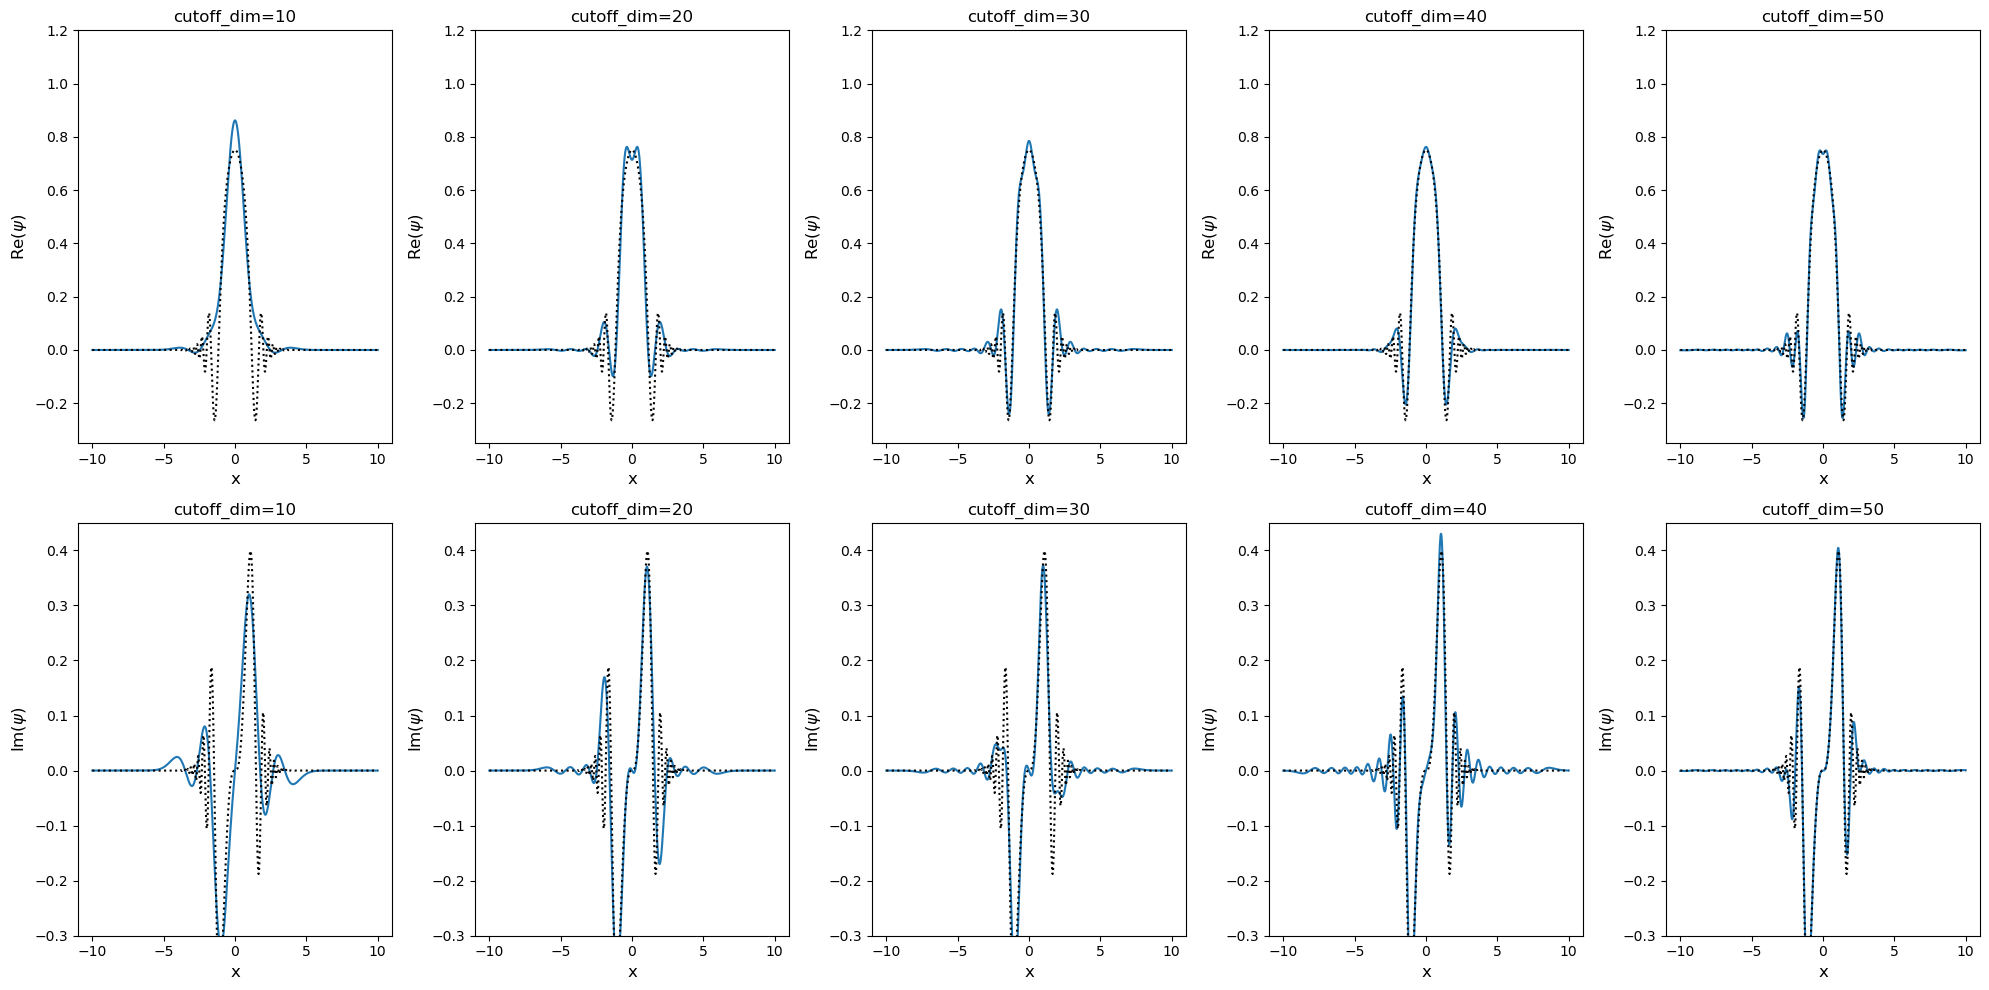

In [7]:
true = 1/np.pi**(1/4)*np.exp(1j*xvec**3 - xvec**2/2)
cutoffs = list(range(10, 51, 5))
cols = 5
fig, ax = plt.subplots(2, cols, figsize=(20, 10))
ax = ax.ravel()
progress = tqdm(total=len(cutoffs))
trace_err = []
mix_err = []
mse_err = []
counter = 0
for cutoff in cutoffs:
    eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff})
    prog = sf.Program(2)
    with prog.context as q:
        Vac | q[0]
        Vac | q[1]
        Vgate(3) | q[0]
        CZgate(2) | (q[0], q[1])
        CZgate(2).H | (q[0], q[1])
    result = eng.run(prog, shots=1)
    fock_dm = result.state.reduced_dm(0)
    probs = result.state.x_quad_values(0, xvec, pvec)
    eigenvalues, eigenvectors = eigh(fock_dm)
    trace_err.append(np.abs(np.trace(fock_dm)))
    mix_err.append(np.max(np.abs(eigenvalues)))
    mse_err.append(np.sum((np.abs(true)**2 - probs)**2))
    fock_rep = eigenvectors[:, np.argmax(eigenvalues)]
    psi = wf_from_fock_pure(fock_rep, xvec)
    mse_real1 = sum([np.abs(np.real(psi[i]) - np.real(true[i]))**2 for i in range(len(psi))])
    mse_real2 = sum([np.abs(np.real(-psi[i]) - np.real(true[i]))**2 for i in range(len(psi))])
    if mse_real1 > mse_real2:
        psi = -psi
    if cutoff%10==0:
        ax[counter].plot(xvec, np.real(psi), label='Quantum Simulation')
        ax[counter+cols].plot(xvec, np.imag(psi), label='Quantum Simulation')
        ax[counter].plot(xvec, np.real(true), color='k', linestyle=':', label='Analytical Solution')
        ax[counter+cols].plot(xvec, np.imag(true), color='k', linestyle=':', label='Analytical Solution')
        ax[counter].set_title(f'cutoff_dim={cutoff}', fontsize=12)
        ax[counter].set_xlabel('x', fontsize=12)
        ax[counter].set_ylabel(r'Re($\psi$)', fontsize=12)
        ax[counter].set_ylim(-.35, 1.2)
        ax[counter+cols].set_title(f'cutoff_dim={cutoff}', fontsize=12)
        ax[counter+cols].set_xlabel('x', fontsize=12)
        ax[counter+cols].set_ylim(-.3, .45)
        ax[counter+cols].set_ylabel(r'Im($\psi$)', fontsize=12)
        counter += 1
    progress.update(1)
progress.close()
plt.tight_layout()
plt.show()


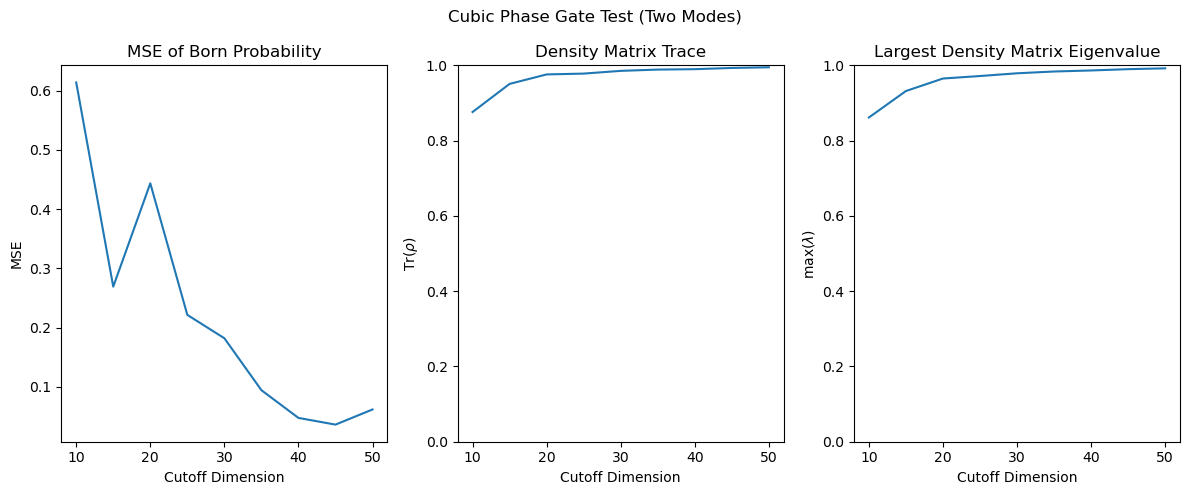

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].plot(cutoffs, mse_err)
ax[0].set_xlabel('Cutoff Dimension')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE of Born Probability')
ax[1].plot(cutoffs, trace_err)
ax[1].set_xlabel('Cutoff Dimension')
ax[1].set_ylabel(r'Tr($\rho$)')
ax[1].set_title('Density Matrix Trace')
ax[2].plot(cutoffs, mix_err)
ax[2].set_xlabel('Cutoff Dimension')
ax[2].set_ylabel(r'max($\lambda$)')
ax[2].set_title('Largest Density Matrix Eigenvalue')
ax[1].set_ylim(0, 1)
ax[2].set_ylim(0, 1)
plt.suptitle('Cubic Phase Gate Test (Two Modes)')
plt.tight_layout()
plt.show()

# Quartic Phase Gate Test

100%|██████████| 9/9 [03:33<00:00, 23.68s/it]


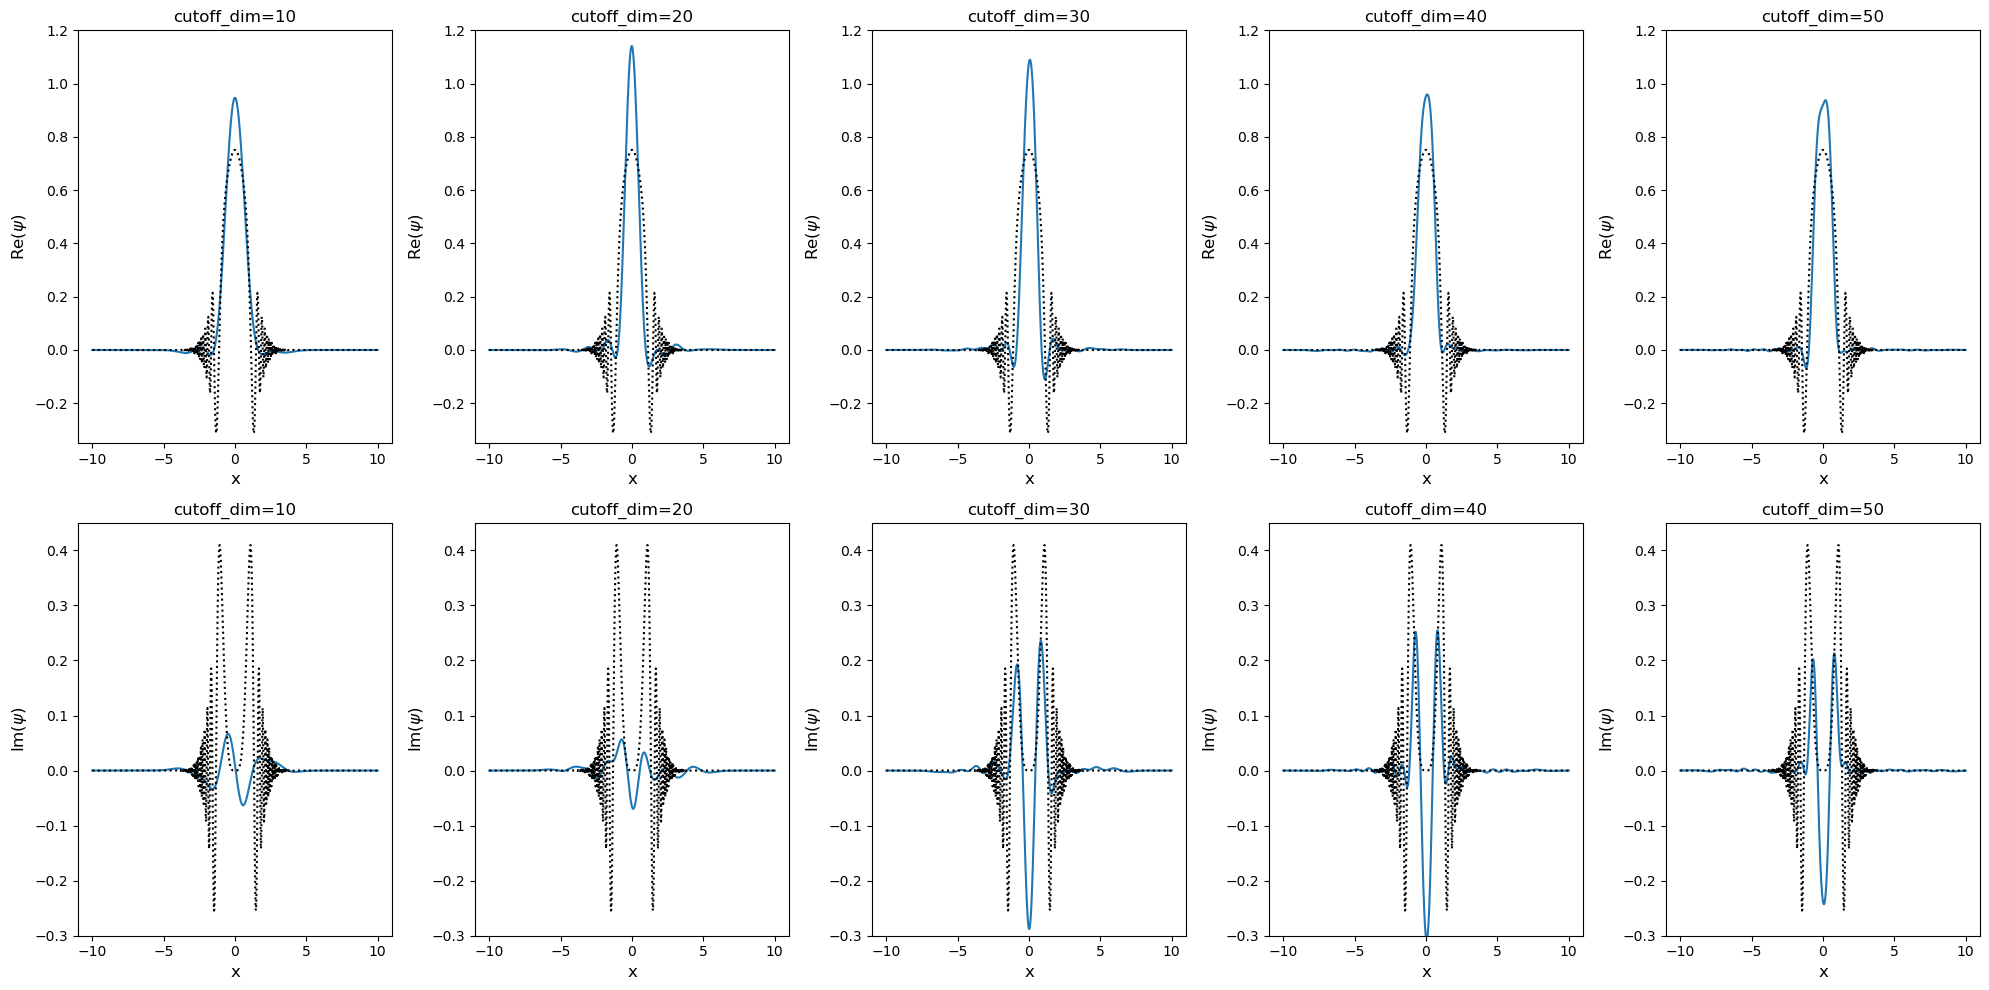

In [9]:
xvec = np.linspace(-10, 10, 1000)
pvec = np.copy(xvec)
true = 1/np.pi**(1/4)*np.exp(1j*xvec**4 - xvec**2/2)
cutoffs = list(range(10, 51, 5))
cols = 5
fig, ax = plt.subplots(2, cols, figsize=(20, 10))
ax = ax.ravel()
progress = tqdm(total=len(cutoffs))
trace_err = []
mix_err = []
mse_err = []
counter = 0
for cutoff in cutoffs:
    eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff})
    prog = sf.Program(2)
    with prog.context as q:
        Vac | q[0]
        Vac | q[1]
        quartic1(1, 0, 1, q)
    result = eng.run(prog, shots=1)
    fock_dm = result.state.reduced_dm(0)
    probs = result.state.x_quad_values(0, xvec, pvec)
    eigenvalues, eigenvectors = eigh(fock_dm)
    trace_err.append(np.abs(np.trace(fock_dm)))
    mix_err.append(np.max(np.abs(eigenvalues)))
    mse_err.append(np.sum((np.abs(true)**2 - probs)**2))
    fock_rep = eigenvectors[:, np.argmax(eigenvalues)]
    psi = wf_from_fock_pure(fock_rep, xvec)
    mse_real = sum([np.abs(np.real(psi[i]) - np.real(true[i]))**2 for i in range(len(psi))])
    mse_imag = sum([np.abs(np.imag(psi[i]) - np.imag(true[i]))**2 for i in range(len(psi))])
    if cutoff%10==0:
        ax[counter].plot(xvec, np.real(psi), label='Quantum Simulation')
        ax[counter+cols].plot(xvec, np.imag(psi), label='Quantum Simulation')
        ax[counter].plot(xvec, np.real(true), color='k', linestyle=':', label='Analytical Solution')
        ax[counter+cols].plot(xvec, np.imag(true), color='k', linestyle=':', label='Analytical Solution')
        ax[counter].set_title(f'cutoff_dim={cutoff}', fontsize=12)
        ax[counter].set_xlabel('x', fontsize=12)
        ax[counter].set_ylabel(r'Re($\psi$)', fontsize=12)
        ax[counter].set_ylim(-.35, 1.2)
        ax[counter+cols].set_title(f'cutoff_dim={cutoff}', fontsize=12)
        ax[counter+cols].set_xlabel('x', fontsize=12)
        ax[counter+cols].set_ylim(-.3, .45)
        ax[counter+cols].set_ylabel(r'Im($\psi$)', fontsize=12)
        counter += 1
    progress.update(1)
progress.close()
plt.tight_layout()
plt.show()


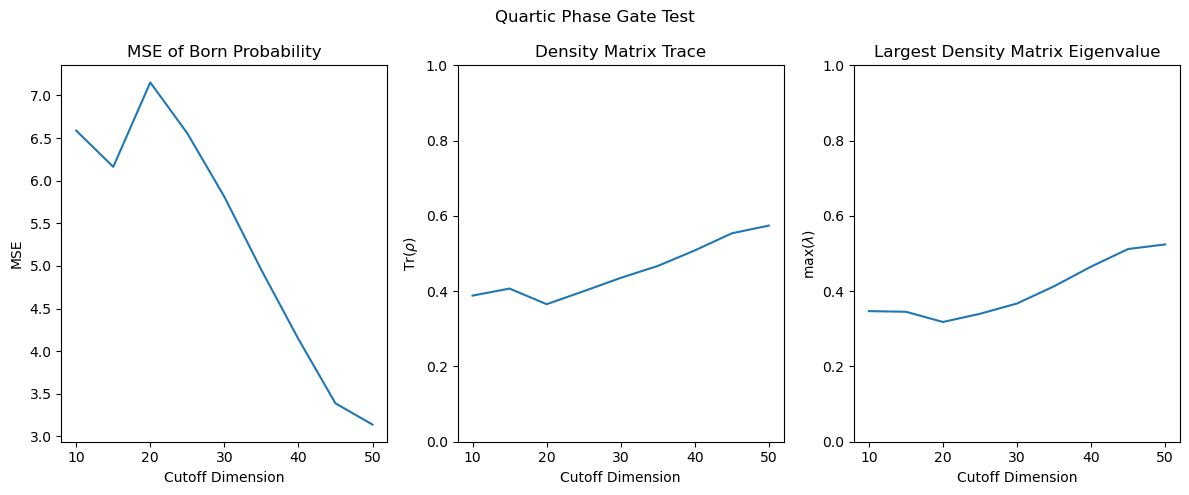

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].plot(cutoffs, mse_err)
ax[0].set_xlabel('Cutoff Dimension')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE of Born Probability')
ax[1].plot(cutoffs, trace_err)
ax[1].set_xlabel('Cutoff Dimension')
ax[1].set_ylabel(r'Tr($\rho$)')
ax[1].set_title('Density Matrix Trace')
ax[2].plot(cutoffs, mix_err)
ax[2].set_xlabel('Cutoff Dimension')
ax[2].set_ylabel(r'max($\lambda$)')
ax[2].set_title('Largest Density Matrix Eigenvalue')
ax[1].set_ylim(0, 1)
ax[2].set_ylim(0, 1)
plt.suptitle('Quartic Phase Gate Test')
plt.tight_layout()
plt.show()